In [315]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
import random
plt.rcParams['figure.figsize'] = [10, 5]

In [ ]:
# Pull in Data
dl = DataLib("SignalData")

LongRates = dl.pull('LongRates')
ShortRates = dl.pull('ShortRates')
BondReturnIndex = dl.pull('BondRetIdx/LocalFX')
BondReturnIndexMonthly = BondReturnIndex.resample('1M').last()
M2 = dl.pull("M2/inUSD")

print(LongRates.index)
print(ShortRates.index)
print(BondReturnIndex.index)
print(M2.index)

In [278]:
# Set Some Constants (Given Business Day as Period)
BUSINESS_YEAR = 5 * 52
BUSINESS_MONTH = 5 * 4

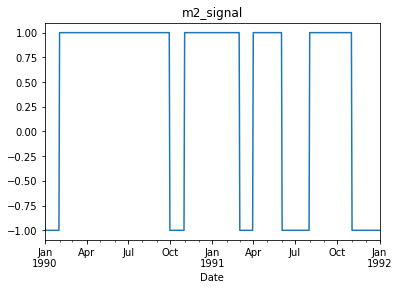

In [275]:
# Dummy Signals used for Testing

# Always Long
AlwaysLong = pd.DataFrame().reindex_like(BondReturnIndex).fillna(1)

# Always Short
AlwaysShort = pd.DataFrame().reindex_like(BondReturnIndex).fillna(-1)

# Gradual Short -> Long
GradualSL = pd.DataFrame().reindex_like(BondReturnIndex).fillna(0)
num_rows, num_cols = GradualSL.shape
for col in GradualSL.columns:
    GradualSL[col] = range(0, num_rows)
GradualSL = 2 * GradualSL / num_rows - 1

# Gradual Long -> Short
GradualLS = -1 * GradualSL

# Sign of M2 Changes
M2Changes = M2.pct_change()
M2Signal = M2Changes / M2Changes.abs()
M2Signal = M2Signal.resample('1B').ffill()

M2Signal['CAN'].plot()
plt.xlabel('Date')
plt.xlim('1990-01','1992-01')
plt.title('m2_signal')
plt.show()

In [511]:
def dailyBondReturns(signal):
    return BondReturnIndex.diff() * signal.shift(1)

def cumulativeBondReturns(signal):
    return dailyBondReturns(signal).cumsum()

def bondReturnsPct(signal, rolling_window):
    return BondReturnIndex.pct_change(rolling_window) * signal.shift(1)

def plotCumulativeReturns(signal, country):
    Returns = cumulativeBondReturns(signal)
    Returns[country].plot()
    BondReturnIndex[country].diff().cumsum().plot()
    plt.xlim('1980-01','2020-06')
    plt.legend(['Returns Using Signal for Country' + country, 'Return Index for Country ' + country])
    plt.xlabel('Date')
    plt.title('Cumulative Returns for Country ' + country)
    plt.show()
    
def plotCumulativePL(signal, country):
    Returns = cumulativeBondReturns(signal)
    (Returns[country] - BondReturnIndex[country]).plot()
    plt.xlim('1980-01','2020-06')
    plt.legend('Cumulative P&L for Country' + country)
    plt.xlabel('Date')
    plt.title('Cumulative P&L for Country ' + country)
    plt.show()
    
def plotReturns(signal, country, rolling_window):
    Returns = bondReturnsPct(signal, rolling_window)
    Returns[country].plot()
    BondReturnIndex[country].pct_change(rolling_window).plot()
    plt.axhline(y=0, color='grey', linestyle='-')
    plt.xlim('1980-01','2020-06')
    plt.legend(['Returns Using Signal for Country' + country, 'Returns for Country ' + country])
    plt.xlabel('Date')
    plt.title('Returns for Country ' + country)
    plt.show()

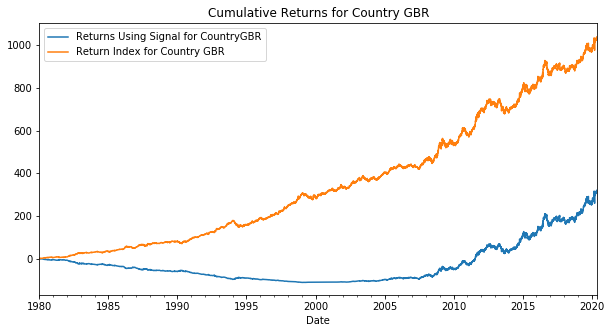

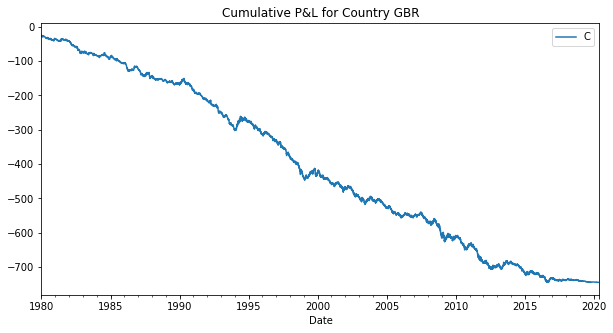

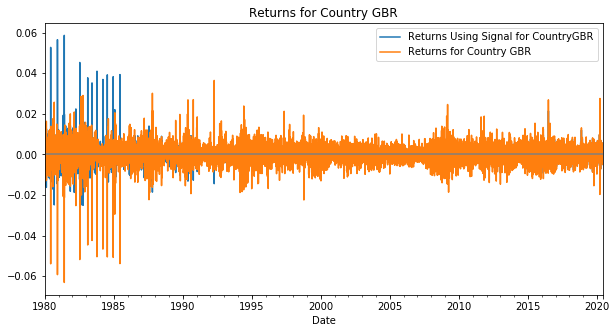

In [512]:
plotCumulativeReturns(gradualSL, 'GBR')
plotCumulativePL(gradualSL, 'GBR')
plotReturns(gradualSL, 'GBR', 1)

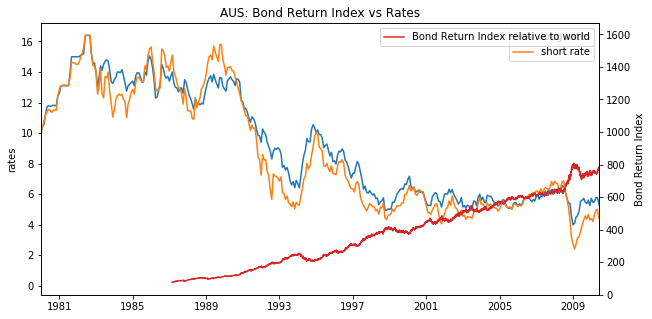

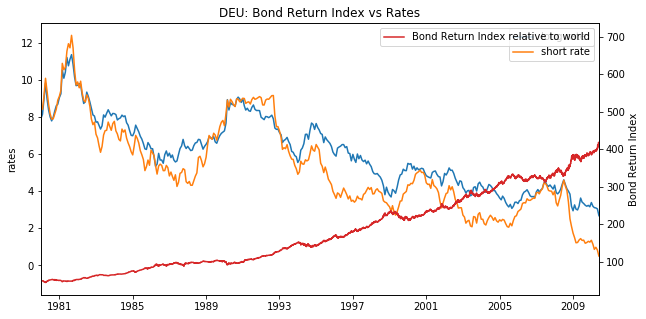

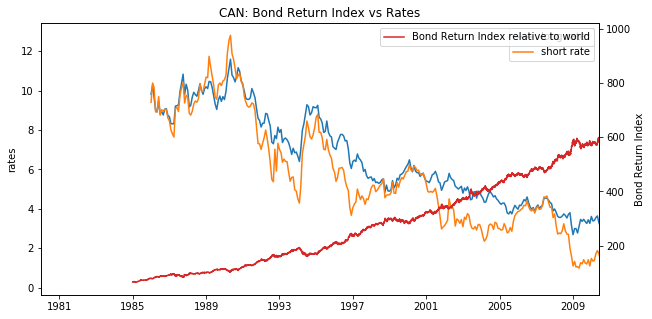

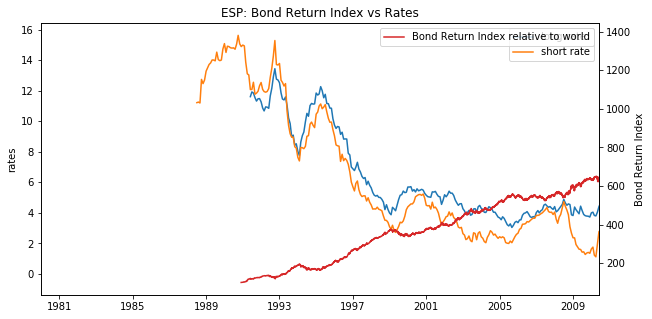

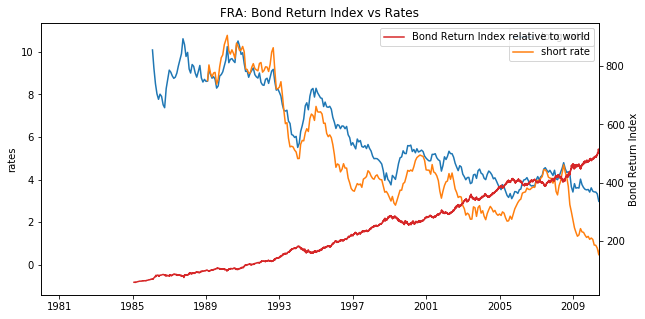

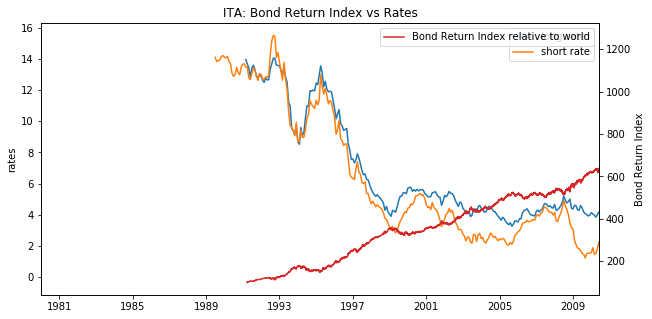

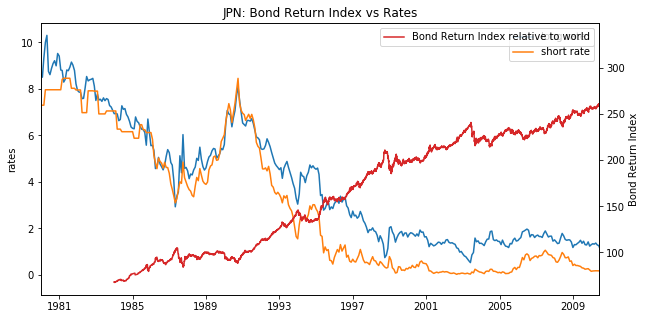

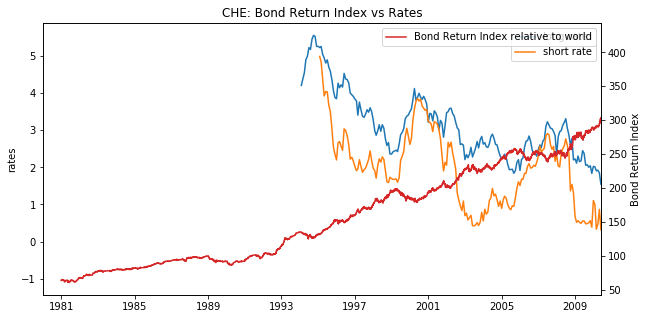

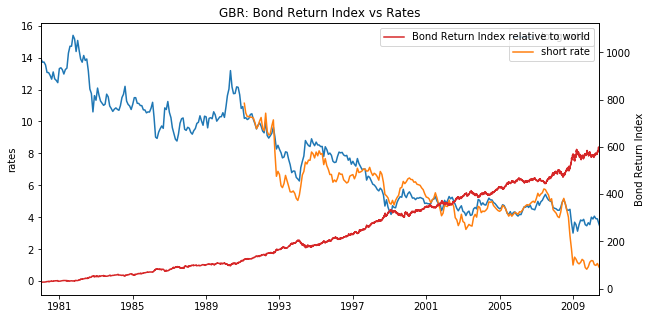

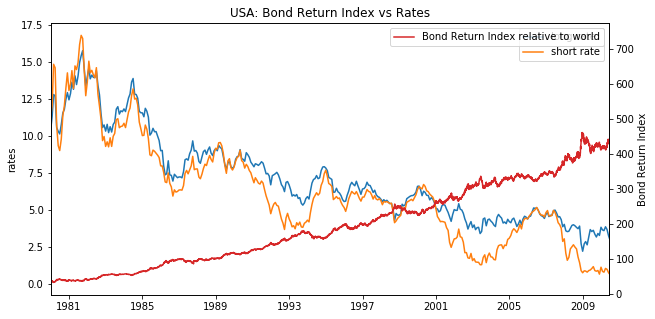

In [513]:
# Visualize bond returns for each country vs long/short rate
for country in BondReturnIndexMonthly.columns:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(LongRates[country].to_timestamp(), label = 'long rate')
    ax1.plot(ShortRates[country].to_timestamp(), label = 'short rate')
    ax1.set_ylabel("rates")
    ax1.legend()
    ax2.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel('Bond Return Index')
    ax2.legend()
    plt.title(country + ': Bond Return Index vs Rates')
    plt.xlim('1980-01','2010-06')
    plt.show()

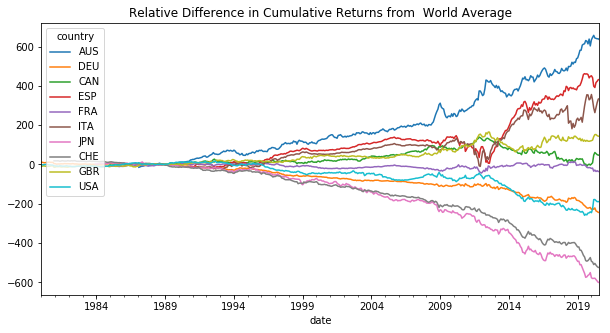

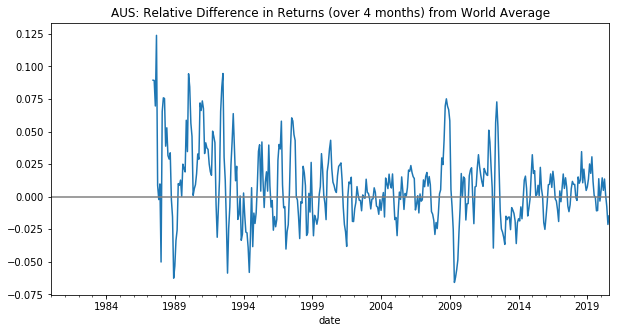

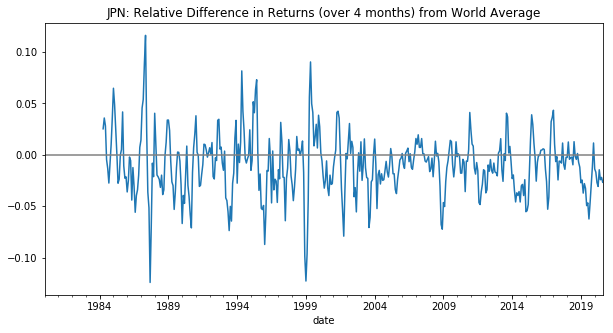

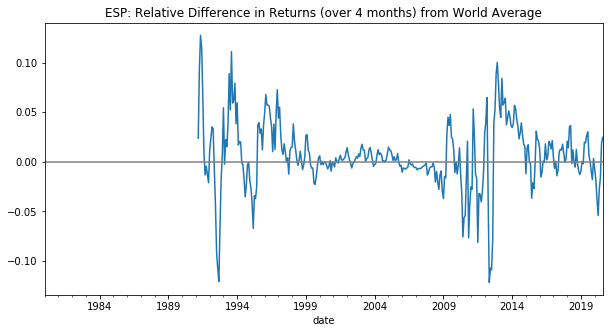

In [501]:
# Deviation in returns from world average

CumBondReturnDifferenceFromWrldAvg = pd.DataFrame().reindex_like(BondReturnIndexMonthly)
for col in BondReturnIndexMonthly.columns:
    CumBondReturnDifferenceFromWrldAvg[col] = BondReturnIndexMonthly[col] - BondReturnIndexMonthly.mean(axis=1)

CumBondReturnDifferenceFromWrldAvg.plot()
plt.title('Relative Difference in Cumulative Returns from  World Average')
plt.show()

BondReturnDifferenceFromWrldAvg = pd.DataFrame().reindex_like(BondReturnIndexMonthly)
for col in BondReturnIndexMonthly.columns:
    BondReturnDifferenceFromWrldAvg[col] = BondReturnIndexMonthly[col].pct_change(4) - BondReturnIndexMonthly.mean(axis=1).pct_change(4)

BondReturnDifferenceFromWrldAvg['AUS'].plot()
plt.axhline(y=0, color='grey', linestyle='-')
plt.title('AUS: Relative Difference in Returns (over 4 months) from World Average')
plt.show()

BondReturnDifferenceFromWrldAvg['JPN'].plot()
plt.axhline(y=0, color='grey', linestyle='-')
plt.title('JPN: Relative Difference in Returns (over 4 months) from World Average')
plt.show()

BondReturnDifferenceFromWrldAvg['ESP'].plot()
plt.axhline(y=0, color='grey', linestyle='-')
plt.title('ESP: Relative Difference in Returns (over 4 months) from World Average')
plt.show()

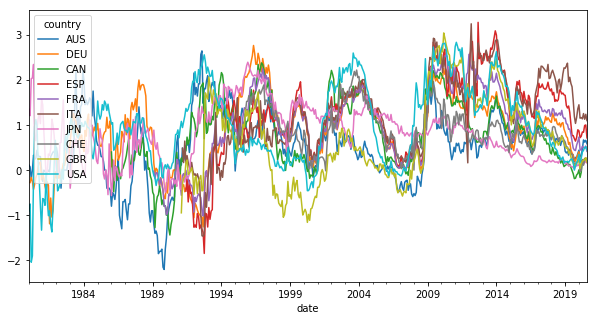

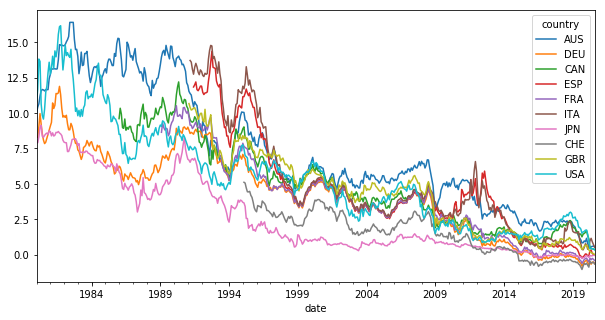

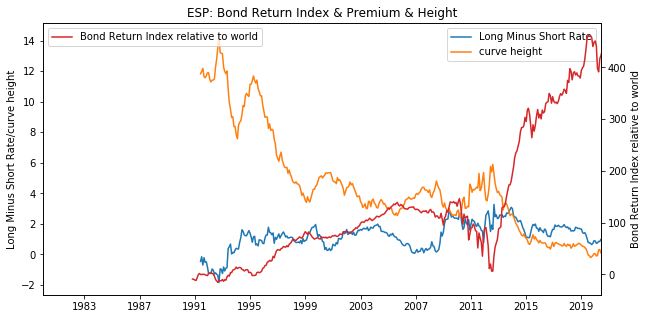

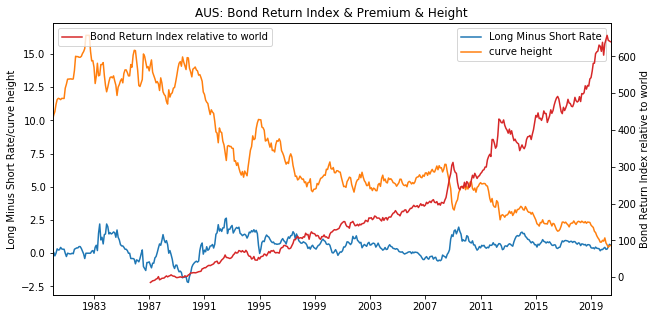

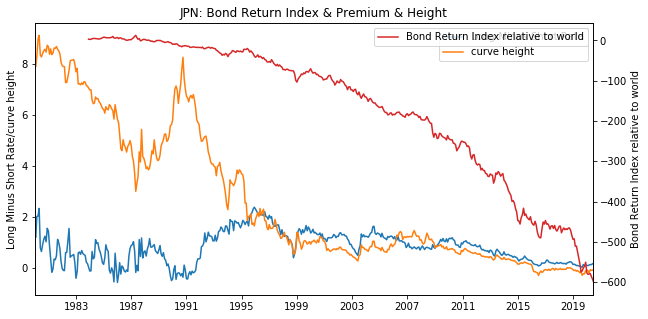

In [520]:
# Research Indicator 1 (Bond Premium = Long-Short Rates & Curve Height)
countries = ['ESP', 'AUS', 'JPN']
LongMinusShortRates = LongRates - ShortRates
CurveHeight = (LongRates + ShortRates) / 2

LongMinusShortRates.plot()
plt.show()
CurveHeight.plot()
plt.show()

for country in countries:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = 'Long Minus Short Rate'
    ax1.plot(LongMinusShortRates[country].to_timestamp(), label = ax1_label)
    ax1.plot(CurveHeight[country].to_timestamp(), label = 'curve height')
    ax1.set_ylabel(ax1_label + "/curve height")
    ax1.legend()
    ax2_label = 'Bond Return Index relative to world'
    BondReturnDifferenceFromWrldAvg = BondReturnIndexMonthly[country] - BondReturnIndexMonthly.mean(axis=1)
    ax2.plot(BondReturnDifferenceFromWrldAvg.to_timestamp(), color = 'tab:red', label = ax2_label)
    ax2.set_ylabel(ax2_label)
    ax2.legend()
    plt.title(country + ': Bond Return Index & Premium & Height')
    plt.xlim('1980-01','2020-06')
    plt.show()

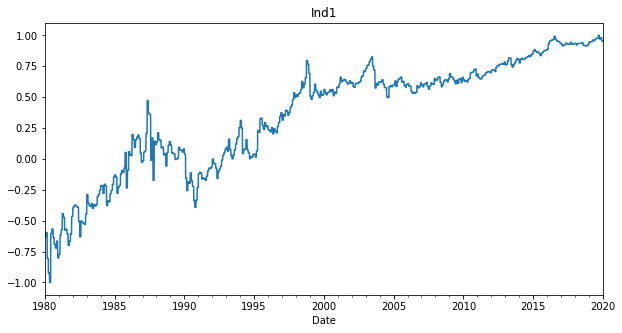

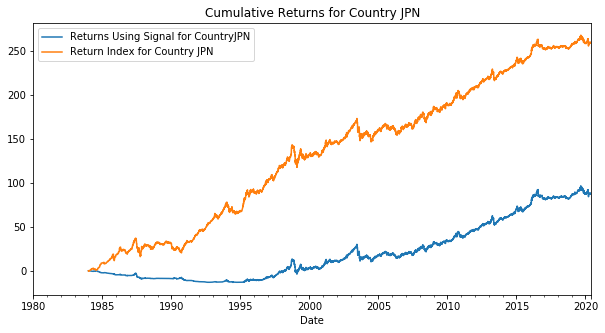

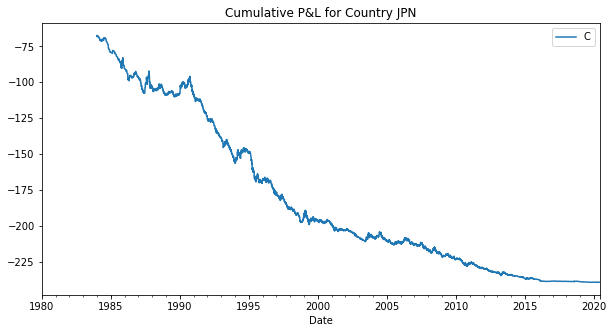

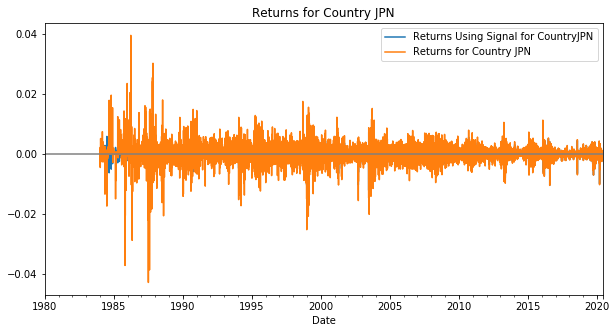

In [521]:
# Create Indicator out of Long - Short & Curve Height (First Pass -- dumb normalization)
Ind1 = LongMinusShortRates.mean() - LongMinusShortRates + CurveHeight.mean() - CurveHeight

# Resample to business days
Ind1 = Ind1.resample('1B').ffill()

# Normalize (min-max) Ind 1
Ind1 = 2 * ((Ind1 - Ind1.min()) / (Ind1.max() - Ind1.min())) - 1

# Plot
Ind1[country].plot()
plt.xlabel('Date')
plt.xlim('1980-01','2020-01')
plt.title('Ind1')
plt.show()

# Show Returns for Ind1
plotCumulativeReturns(Ind1, country)
plotCumulativePL(Ind1, country)
plotReturns(Ind1, country, 1)

In [517]:
# Current Todos:
# - Work on first indicator and make sure I am standardizing with respect to country and between countries
# - Basically keep pushing indicator until it becomes active signal

# Question 1: Does absolute value of bond premium and curve height have anything to do with bond returns?
    # If it does, when does the price change take effect? The day after? The month after? The year after?
# Question 2: Does month-to-month/year-to-year change in value of bond premium and curve height have anything to do with bond returns?
    # If it does, when does the price change take effect? The day after? The month after? The year after?

# Question 3: Overall, the bond returns overwhelmingly go up for every country.
# In order to make money, is the best method to accurately predict when to short a particular country and otherwise mostly long?
# Is the goal to accurately predict when a country is becoming much worse/much better relative to the global movement?
    # If so, when analyzing, should I be looking at difference between country's return index and global average return index?
    # Or, difference in country's percent return and global average's percent return?
    # Also, how to structure bet? Relative increase in returns for country X = long X, short world. Opposite opinion = vice versa 
    
    
# Other indicators I plan to explore: FX Appreciation, M2 base

# With M2 base, given that it is a slow-moving predictor, 
# I will do an analysis where I align predictions from indicator with actual movements with various lags to determine
# which lag is best (how long it takes for predictions to come true)

# With FX appreciation, I will start by seeing if FX appreciation predicts lowering of rates